# 1. Imports

In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np

# 2. Data 

## 2.1 Loaders

W tej sekcji pobieramy dane MNIST, normalizujemy dane oraz porządkujemy do odpowiednich zbiorów: testowych, treningowych i walidacyjnych.
Dzielimy również dane na podzbiory.

### 2.1.1 MNIST Data

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])
batch_size = 64

datasets_save_dir = 'Data/'

train_data = datasets.MNIST(root=datasets_save_dir,download=True,train=True, 
    transform=transform)
test_data = datasets.MNIST(root=datasets_save_dir,download=True,train=False, 
    transform=transform)

all_train_size = len(train_data)
little_train_size = int(0.8 * all_train_size)
val_size = all_train_size - little_train_size

little_train_dataset, val_dataset = random_split(train_data, [little_train_size, val_size])

little_train_dataloader = DataLoader(little_train_dataset,batch_size=batch_size,
    shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

### 2.1.2 Subsets

In [4]:
subset_sizes = [1000*i for i in range(1,6)] 

subset_loaders = []
for subset_size in subset_sizes:
    subset, _ = random_split(little_train_dataset, [subset_size, little_train_size  - subset_size])
    subset_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    subset_loaders.append(subset_loader)

## 2.2 Data shape

In [5]:
for images, labels in little_train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# 3. Models

## 3.1 Standard Fcnn

In [6]:
class Fcnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x
    

    def weights_normal(self,mean,std):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=mean, std=std) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def weights_ones(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.ones_(m.weight) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

## 3.2 Fcnn + dropout

In [7]:
class Fcnn_dropout(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x

# 4. Utility functions

In [8]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
         
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train(epochs:int,model,optimizer,criterion,data,early_stop = False):
    if early_stop:
        early_stopper = EarlyStopper(patience=3)
    model.train()
    loss_history = []
    for epoch in range(epochs):
        batch_loss = []
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels) 
            loss.backward()

            optimizer.step()
            
            batch_loss.append(loss.item())
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(data)}, loss: {loss.item():.4f}')
        avg_batch_loss = sum(batch_loss)/len(batch_loss)
        loss_history.append(avg_batch_loss)
        print(f'Epoch: {epoch+1}, loss: {avg_batch_loss}')

        if early_stop:
            if early_stopper.early_stop(avg_batch_loss):
                print('Early stopping!')
                break
            
    print('Finished training!')
    return loss_history



In [9]:
def test(model, dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (images,labels) in enumerate(dataloader):
            images = images.view(images.shape[0],-1)

            output = model(images)
            pred = output.data.max(1,keepdim=True)[1]
            
            labels = labels.data.view_as(pred)
            correct += pred.eq(labels).sum()
    accuracy = correct/len(dataloader.dataset)
    print(f'Accuracy: {accuracy:.3f}')
    return accuracy


# 5. Weight initialization

W tej sekcji będziemy zajmować się analizą różnych podejść do inicjalizacji wag. Omawiane będą następujące modele:
1. Model z wagami bliskimi 0 (bez manualnej inicjalizacji)
2. Model z dużymi wagami, gdzie $\mu=1000$ oraz $\sigma = 20$
3. Model z wagami równymi 1

## 5.1 Settings

In [10]:
epochs = 8
criterion = nn.CrossEntropyLoss()

## 5.2 Training

### 5.2.1 No manual weight initialization (weights near 0)

In [11]:
model_1 = Fcnn()
optimizer = torch.optim.Adam(model_1.parameters())

loss_history_1 = train(epochs, model_1, optimizer, criterion, little_train_dataloader)

/home/luki/Documents/Projects/MNIST_fcnn/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/750, loss: 1.7820
epoch: 1, step: 200/750, loss: 1.5904
epoch: 1, step: 300/750, loss: 1.6091
epoch: 1, step: 400/750, loss: 1.5411
epoch: 1, step: 500/750, loss: 1.5535
epoch: 1, step: 600/750, loss: 1.5526
epoch: 1, step: 700/750, loss: 1.5459
Epoch: 1, loss: 1.637616822719574
epoch: 2, step: 100/750, loss: 1.5837
epoch: 2, step: 200/750, loss: 1.5302
epoch: 2, step: 300/750, loss: 1.5117
epoch: 2, step: 400/750, loss: 1.5385
epoch: 2, step: 500/750, loss: 1.5583
epoch: 2, step: 600/750, loss: 1.5445
epoch: 2, step: 700/750, loss: 1.4937
Epoch: 2, loss: 1.5474432376225788
epoch: 3, step: 100/750, loss: 1.5628
epoch: 3, step: 200/750, loss: 1.5184
epoch: 3, step: 300/750, loss: 1.5516
epoch: 3, step: 400/750, loss: 1.5474
epoch: 3, step: 500/750, loss: 1.5239
epoch: 3, step: 600/750, loss: 1.5466
epoch: 3, step: 700/750, loss: 1.5724
Epoch: 3, loss: 1.5294037280082702
epoch: 4, step: 100/750, loss: 1.5136
epoch: 4, step: 200/750, loss: 1.5290
epoch: 4, step: 300/75

### 5.2.2 Large weights

In [12]:
model_2 = Fcnn()
optimizer = torch.optim.Adam(model_2.parameters())
model_2.weights_normal(mean=1000, std=20)

loss_history_2 = train(epochs, model_2, optimizer, criterion, little_train_dataloader)

epoch: 1, step: 100/750, loss: 2.3022
epoch: 1, step: 200/750, loss: 2.3020
epoch: 1, step: 300/750, loss: 2.3018
epoch: 1, step: 400/750, loss: 2.3026
epoch: 1, step: 500/750, loss: 2.3011
epoch: 1, step: 600/750, loss: 2.3017
epoch: 1, step: 700/750, loss: 2.3019
Epoch: 1, loss: 2.3023464981714885
epoch: 2, step: 100/750, loss: 2.3030
epoch: 2, step: 200/750, loss: 2.3012
epoch: 2, step: 300/750, loss: 2.2988
epoch: 2, step: 400/750, loss: 2.3011
epoch: 2, step: 500/750, loss: 2.3006
epoch: 2, step: 600/750, loss: 2.3008
epoch: 2, step: 700/750, loss: 2.3014
Epoch: 2, loss: 2.301921722730001
epoch: 3, step: 100/750, loss: 2.3000
epoch: 3, step: 200/750, loss: 2.3041
epoch: 3, step: 300/750, loss: 2.3006
epoch: 3, step: 400/750, loss: 2.3040
epoch: 3, step: 500/750, loss: 2.2988
epoch: 3, step: 600/750, loss: 2.3008
epoch: 3, step: 700/750, loss: 2.3017
Epoch: 3, loss: 2.3016322673161826
epoch: 4, step: 100/750, loss: 2.3020
epoch: 4, step: 200/750, loss: 2.3050
epoch: 4, step: 300/75

### 5.2.3 All weights set to 1

In [13]:
model_3 = Fcnn()
optimizer = torch.optim.Adam(model_3.parameters())
model_3.weights_ones()

loss_history_3 = train(epochs, model_3, optimizer, criterion, little_train_dataloader)

epoch: 1, step: 100/750, loss: 2.3023
epoch: 1, step: 200/750, loss: 2.3026
epoch: 1, step: 300/750, loss: 2.3022
epoch: 1, step: 400/750, loss: 2.3024
epoch: 1, step: 500/750, loss: 2.3036
epoch: 1, step: 600/750, loss: 2.3016
epoch: 1, step: 700/750, loss: 2.3027
Epoch: 1, loss: 2.302322836558024
epoch: 2, step: 100/750, loss: 2.3016
epoch: 2, step: 200/750, loss: 2.3034
epoch: 2, step: 300/750, loss: 2.3028
epoch: 2, step: 400/750, loss: 2.3000
epoch: 2, step: 500/750, loss: 2.3045
epoch: 2, step: 600/750, loss: 2.3033
epoch: 2, step: 700/750, loss: 2.3007
Epoch: 2, loss: 2.3019002793629966
epoch: 3, step: 100/750, loss: 2.2993
epoch: 3, step: 200/750, loss: 2.3014
epoch: 3, step: 300/750, loss: 2.3046
epoch: 3, step: 400/750, loss: 2.3093
epoch: 3, step: 500/750, loss: 2.3025
epoch: 3, step: 600/750, loss: 2.3037
epoch: 3, step: 700/750, loss: 2.2980
Epoch: 3, loss: 2.301624276161194
epoch: 4, step: 100/750, loss: 2.2987
epoch: 4, step: 200/750, loss: 2.3017
epoch: 4, step: 300/750

## 5.3 Results

### 5.3.1 Testing

In [14]:
accuracy_1 = test(model_1, test_dataloader)
accuracy_2 = test(model_2, test_dataloader)
accuracy_3 = test(model_3, test_dataloader)
print(f'Model 1 accuracy: {accuracy_1:.2f}, Model 2 accuracy: {accuracy_2:.2f}, Model 3 accuracy: {accuracy_3:.2f}')

Accuracy: 0.952
Accuracy: 0.113
Accuracy: 0.113
Model 1 accuracy: 0.95, Model 2 accuracy: 0.11, Model 3 accuracy: 0.11


### 5.3.2 Visualization

#### 5.3.2.1 Loss function 

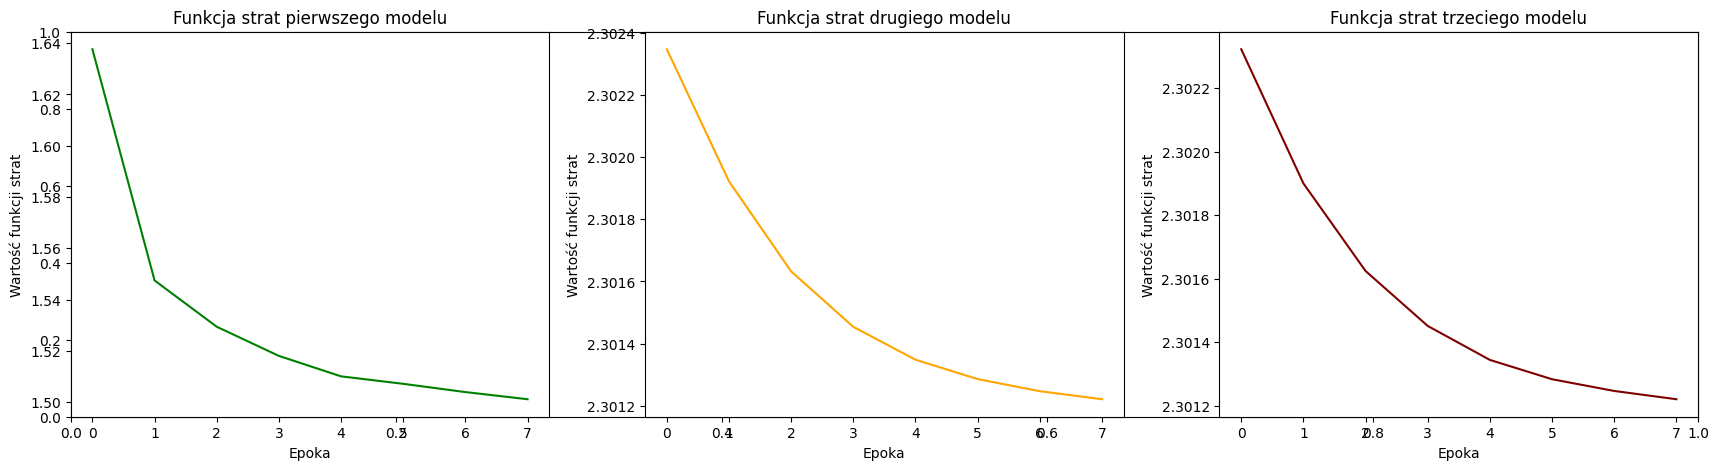

In [15]:
plt.subplots(figsize=(21, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_history_1, color='green')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat pierwszego modelu')

plt.subplot(1, 3, 2)
plt.plot(loss_history_2, color='orange')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat drugiego modelu')

plt.subplot(1, 3, 3)
plt.plot(loss_history_3, color='maroon')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat trzeciego modelu')

plt.show()

#### 5.3.2.2 Accuracy barplots

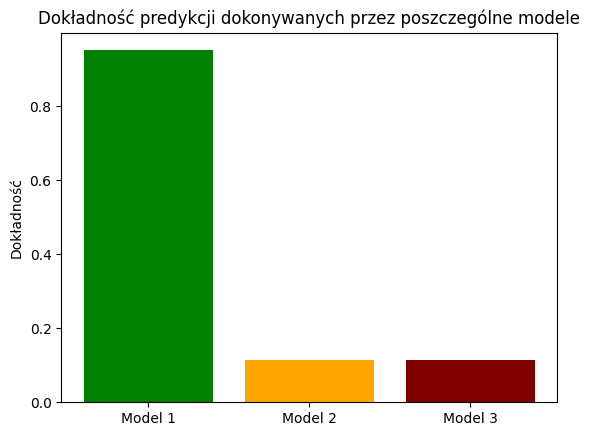

In [16]:
plt.bar(['Model 1', 'Model 2', 'Model 3'], [accuracy_1, accuracy_2, accuracy_3], color=['green', 'orange', 'maroon'])
plt.title('Dokładność predykcji dokonywanych przez poszczególne modele')
plt.ylabel('Dokładność')

plt.show()

Domyślne wagi zaimplementowane przez PyTorch (użyte w pierwszym modelu), czyli bardzo bliskie 0, działają najlepiej. Wyniki uzyskiwane przez model można wówczas uznać za satysfakcjonujące. Inicjalizacja innych wag sprawia, że wyniki predykcji modelu są bardzo dalekie od oczekiwań. Dotyczy to zarówno poprawności predykcji jak i funkcji strat.

# 6. Training on subsets of different sizes

W tym rozdziale zajmiemy się analizą uczenia sieci neuronowej w zależności od wielkości zbioru treningowego.
Następnie porównamy dokładność tych sieci na zbiorze walidacyjnym oraz testowym. 

## 6.1 Training loop

In [31]:
subset_loss_history = []
subset_accuracy_train = []
subset_accuracy_test = []

num_epochs = 6

for subset in subset_loaders:
    subset_model = Fcnn()
    optimizer = torch.optim.Adam(subset_model.parameters())
    loss_history = train(num_epochs,subset_model,optimizer,criterion,subset)
    subset_loss_history.append(loss_history)

    accuracy_test = test(subset_model,test_dataloader)
    accuracy_train = test(subset_model,val_dataloader)
    
    subset_accuracy_train.append(accuracy_train)
    subset_accuracy_test.append(accuracy_test)

/home/luki/Documents/Projects/MNIST_fcnn/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1, loss: 2.2165221571922302
Epoch: 2, loss: 2.023239053785801
Epoch: 3, loss: 1.8768161684274673
Epoch: 4, loss: 1.7980473637580872
Epoch: 5, loss: 1.7656072080135345
Epoch: 6, loss: 1.7474304214119911
Finished training!
Accuracy: 0.715
Accuracy: 0.707
Epoch: 1, loss: 2.1318913847208023
Epoch: 2, loss: 1.8533506467938423
Epoch: 3, loss: 1.7735392414033413
Epoch: 4, loss: 1.6988525316119194
Epoch: 5, loss: 1.6617873907089233
Epoch: 6, loss: 1.6461874768137932
Finished training!
Accuracy: 0.807
Accuracy: 0.794
Epoch: 1, loss: 2.0659541373557233
Epoch: 2, loss: 1.7308659528164154
Epoch: 3, loss: 1.6719354315006987
Epoch: 4, loss: 1.6507627000199987
Epoch: 5, loss: 1.6394726976435234
Epoch: 6, loss: 1.6268921532529466
Finished training!
Accuracy: 0.825
Accuracy: 0.812
Epoch: 1, loss: 2.0129628749120805
Epoch: 2, loss: 1.718694043537927
Epoch: 3, loss: 1.6671548287073772
Epoch: 4, loss: 1.6501702164846754
Epoch: 5, loss: 1.6416790561070518
Epoch: 6, loss: 1.6285659188315982
Finished 

## 6.2 Results visualized

### 6.2.1 Accuracy

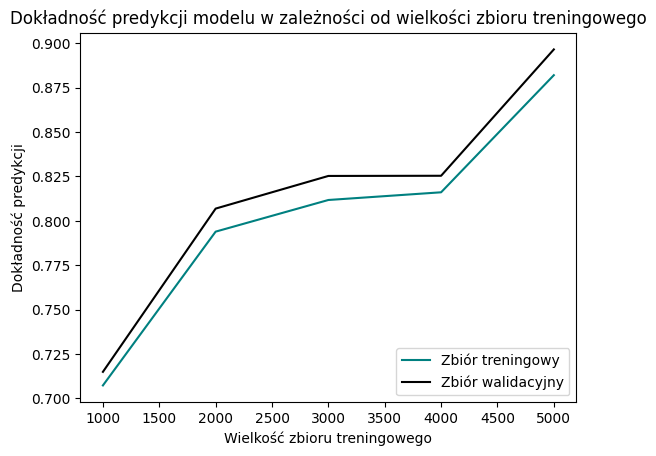

In [32]:
plt.plot(subset_sizes, subset_accuracy_train, label='Zbiór treningowy', color='teal')
plt.plot(subset_sizes, subset_accuracy_test, label='Zbiór walidacyjny', color='black')

plt.xlabel('Wielkość zbioru treningowego')
plt.ylabel('Dokładność predykcji')
plt.title('Dokładność predykcji modelu w zależności od wielkości zbioru treningowego')

plt.legend(loc='lower right')

Na powyższym wykresie możemy zauważyć trend wzrostowy w zależności pomiędzy zwiększaniem zbioru treningowego a dokładnością predykcji modelu.

### 6.2.2 Loss

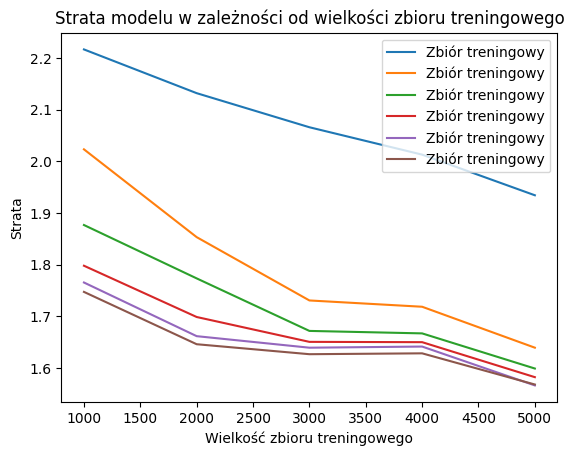

In [43]:
plt.plot(subset_sizes, subset_loss_history, label='Zbiór treningowy')

plt.xlabel('Wielkość zbioru treningowego')
plt.ylabel('Strata')
plt.title('Strata modelu w zależności od wielkości zbioru treningowego')

plt.legend(loc='upper right')

# 7. Early stopping

W tym rozdziale zajmiemy się pokazaniem, w jaki sposób działa uczenie sieci neuronowej z zastosowaniem early-stoppingu. Ze względu na dużą ilość danych, by łatwiej było aktywować proces overfittingu, a tym samym aktywowania early-stoppingu, szybkość uczenia jest bardzo wysoka i wynosi 0.6. 

## 7.1 Training

In [24]:
epochs = 35

model_4 = Fcnn()
learning_rate = 0.6
optimizer = torch.optim.SGD(model_4.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
loss_history_4 = train(epochs, model_4, optimizer, criterion, data=train_dataloader,early_stop=True)

epoch: 1, step: 100/938, loss: 1.8025
epoch: 1, step: 200/938, loss: 1.8273
epoch: 1, step: 300/938, loss: 1.6209
epoch: 1, step: 400/938, loss: 1.6840
epoch: 1, step: 500/938, loss: 1.5913
epoch: 1, step: 600/938, loss: 1.6161
epoch: 1, step: 700/938, loss: 1.5087
epoch: 1, step: 800/938, loss: 1.5616
epoch: 1, step: 900/938, loss: 1.5221
Epoch: 1, loss: 1.6767787432619758
epoch: 2, step: 100/938, loss: 1.5965
epoch: 2, step: 200/938, loss: 1.6440
epoch: 2, step: 300/938, loss: 1.5569
epoch: 2, step: 400/938, loss: 1.5065
epoch: 2, step: 500/938, loss: 1.5508
epoch: 2, step: 600/938, loss: 1.5434
epoch: 2, step: 700/938, loss: 1.6170
epoch: 2, step: 800/938, loss: 1.5794
epoch: 2, step: 900/938, loss: 1.5026
Epoch: 2, loss: 1.556223905544037
epoch: 3, step: 100/938, loss: 1.5379
epoch: 3, step: 200/938, loss: 1.5228
epoch: 3, step: 300/938, loss: 1.5405
epoch: 3, step: 400/938, loss: 1.4946
epoch: 3, step: 500/938, loss: 1.5275
epoch: 3, step: 600/938, loss: 1.5152
epoch: 3, step: 700

## 7.2 Test

In [25]:
accuracy_4 = test(model_4, test_dataloader)

Accuracy: 0.954


## 7.3 Visualization

Text(0.5, 1.0, 'Loss by epoch')

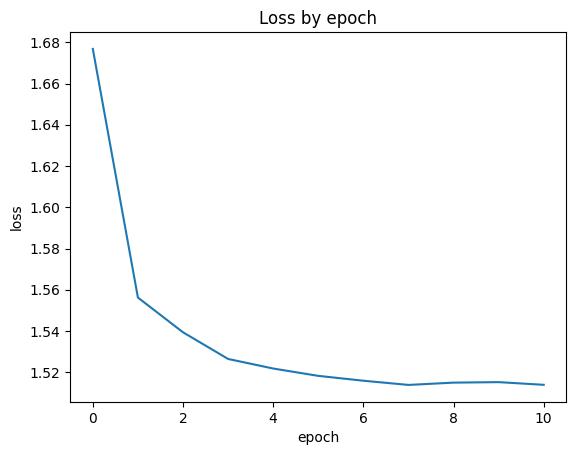

In [45]:
plt.plot(loss_history_4)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss by epoch')

Na wykresie powyżej widać od pewnego momentu wzrost funkcji strat. Po ustalonych trzech epokach takiego wzrostu zadziałał early-stopping i zakończył trening.

# 8. Dropout

In [28]:
model_5 = Fcnn_dropout()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters())

epochs = 8
train(epochs, model_5, optimizer, criterion, data=train_dataloader,early_stop=True)

epoch: 1, step: 100/938, loss: 1.8484
epoch: 1, step: 200/938, loss: 1.6844
epoch: 1, step: 300/938, loss: 1.6773
epoch: 1, step: 400/938, loss: 1.6760
epoch: 1, step: 500/938, loss: 1.7279
epoch: 1, step: 600/938, loss: 1.7103
epoch: 1, step: 700/938, loss: 1.6365
epoch: 1, step: 800/938, loss: 1.7220
epoch: 1, step: 900/938, loss: 1.6024
Epoch: 1, loss: 1.703415725658189
epoch: 2, step: 100/938, loss: 1.6964
epoch: 2, step: 200/938, loss: 1.6239
epoch: 2, step: 300/938, loss: 1.6341
epoch: 2, step: 400/938, loss: 1.6528
epoch: 2, step: 500/938, loss: 1.5469
epoch: 2, step: 600/938, loss: 1.5106
epoch: 2, step: 700/938, loss: 1.4781
epoch: 2, step: 800/938, loss: 1.5361
epoch: 2, step: 900/938, loss: 1.6098
Epoch: 2, loss: 1.5933593676796853
epoch: 3, step: 100/938, loss: 1.5428
epoch: 3, step: 200/938, loss: 1.5111
epoch: 3, step: 300/938, loss: 1.4987
epoch: 3, step: 400/938, loss: 1.5805
epoch: 3, step: 500/938, loss: 1.5405
epoch: 3, step: 600/938, loss: 1.5355
epoch: 3, step: 700

[1.703415725658189,
 1.5933593676796853,
 1.5392378905434598,
 1.529941413067043,
 1.5248294152430635,
 1.5187479954030214,
 1.5194306766300567,
 1.5160780163970329]

In [29]:
accuracy_5 = test(model_5, test_dataloader)

Accuracy: 0.960


Sieć z wykorzystaniem dropoutu świetnie sobie radzi - przy tej samej funkcji strat oraz optimizera (rodział 5), sieć osiąga dokładność o prawie 1 punkt procentowy więcej. Dropout nie zadziałał, gdyż liczba epok była jeszcze zbyt mała.